In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
from glob import glob
import time
import cooler
from itertools import cycle, islice
from sklearn.decomposition import PCA
from scipy.stats import pearsonr, spearmanr, ttest_ind
from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import glob
import pathlib
# mpl.style.use('default')
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'sans-serif'
# mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
group_name = 'Oligo_NN'
ct = group_name

In [3]:
res = 100000
chrom_size_path = '/ref/m3C/mm10.main.nochrM.nochrY.chrom.sizes'
chrom_sizes = cooler.read_chromsizes(chrom_size_path, all_names=True)

In [4]:
bins_df = cooler.binnify(chrom_sizes, res)
bins_df.index = bins_df['chrom'].astype(str) + '-' + (bins_df['start'] // res).astype(str)
bins_df.head()

,chrom,start,end
chr1-0,chr1,0,100000
chr1-1,chr1,100000,200000
chr1-2,chr1,200000,300000
chr1-3,chr1,300000,400000
chr1-4,chr1,400000,500000


In [5]:
cpg = pd.read_hdf('cpg_ratio_100k.hdf')
cpg.head()

,chrom,start,end,cpg_ratio
0,chr1,0,100000,0.0
1,chr1,100000,200000,0.0
2,chr1,200000,300000,0.0
3,chr1,300000,400000,0.0
4,chr1,400000,500000,0.0


## Select PC with celltype raw matrices

In [6]:
Qall = []
binall = []
#cwd = os.getcwd()
indir = f'{cwd}/CellType.Merged.Mcool'

In [7]:
cool = cooler.Cooler(f'{indir}/{ct}.raw.mcool::resolutions/100000')
fig, axes = plt.subplots(5, 4, figsize=(15,15))
for i,c in enumerate(chrom_sizes.index):
    Q = cool.matrix(balance=False, sparse=True).fetch(c).toarray()
    Q = Q - np.diag(np.diag(Q))
    rowsum = Q.sum(axis=0)
    thres = [np.percentile(rowsum[rowsum>0], 50), np.percentile(rowsum[rowsum>0], 99)]
    thres.append(thres[0]*2-thres[1])
    ax = axes.flatten()[i]
    sns.histplot(rowsum, bins=100, ax=ax)
    for t in thres:
        ax.plot([t, t], [0, ax.get_ylim()[1]*0.5], c='r')
    ax.set_title(c)
    binfilter = (rowsum>thres[-1])
    binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    Qall.append(Q)
    #print(c)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')

fig, axes = plt.subplots(5, 4, figsize=(15,15))
for i,c in enumerate(chrom_sizes.index):
    ax = axes.flatten()[i]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Qall[i]
    ax.imshow(tmp, cmap='bwr', vmin=-np.percentile(Qall[i], 95), vmax=np.percentile(Qall[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)

for i in range(chrom_sizes.shape[0], axes.flatten().shape[0]):
    axes.flatten()[i].axis('off')
    
plt.tight_layout()
# plt.savefig(f'{indir}/plot/celltype_A_decay.pdf', transparent=True)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/qzeng_salk_edu/project/240204-redo-compartment/CellType.Merged.Mcool/Oligo_NN.raw.mcool', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
selpc = {}
indir = f'{cwd}/CellType.Merged.Mcool'
cool = cooler.Cooler(f'{indir}/{ct}.raw.mcool::resolutions/100000')

pcall, Call, binall, selall = [], [], [], []
for k,chrom in enumerate(chrom_sizes.index):
    ## Load matrix
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))

    ## Filter bins by coverage
    rowsum = Q.sum(axis=0)
    thres = [np.percentile(rowsum[rowsum>0], 50), np.percentile(rowsum[rowsum>0], 99)]
    thres.append(thres[0]*2-thres[1])
    binfilter = (rowsum>thres[-1])
    binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]

    ## Dist norm and corr
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    Call.append(C)
    pca = PCA(n_components=2)
    pc = pca.fit_transform(C)
    cpgtmp = cpg.loc[cpg['chrom']==chrom, 'cpg_ratio'].values[binfilter]

    ## Correct direction of PC
    for i in range(2):
        if pearsonr(cpgtmp, pc[:,i])[0]>0:
            pc[:,i] = pc[:,i]
        else:
            pc[:,i] = -pc[:,i]
    pcall.append(pc)

    ## Select PC by pearsonr
    if np.abs(pearsonr(cpgtmp, pc[:,0])[0])>np.abs(pearsonr(cpgtmp, pc[:,1])[0]):
        i1 = 0
    else:
        i1 = 1

    ## Select PC by spearmanr
    if np.abs(spearmanr(cpgtmp, pc[:,0])[0])>np.abs(pearsonr(cpgtmp, pc[:,1])[0]):
        i2 = 0
    else:
        i2 = 1
    
    ## Select PC by comp strength
    r = []
    for i in range(2):
        labels, groups = pd.qcut(pc[:,i], 50, labels=False, retbins=True)
        sad = np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count = np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
        sad = sad / count
        r.append((sad[:10, :10].sum() + sad[-10:, -10:].sum()) / (sad[:10, -10:].sum() + sad[-10:, :10].sum()))
    if r[0]>r[1]:
        i3 = 0
    else:
        i3 = 1
    
    selall.append([i1, i2, i3])
    print(chrom, i1, i2, i3)

selpc[ct] = selall

## Plot Corr and 2 PCs
fig, axes = plt.subplots(3, 22, figsize=(66,4), gridspec_kw={'height_ratios':[5, 0.4, 0.4]}, sharex='col')
for i,c in enumerate(chrom_sizes.index):
    ax = axes[0,i]
    n_bins = int(chrom_sizes[c] // 100000) + 1
    tmp = np.zeros((n_bins, n_bins))
    tmp[np.ix_(binall[i], binall[i])] = Call[i]
    ax.imshow(tmp, cmap='bwr', vmin=np.percentile(Call[i], 5), vmax=np.percentile(Call[i], 95))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(c, fontsize=15)

    for j in range(2):
        ax = axes[j+1,i]
        # ax.set_title('PC1', fontsize=10)
        sns.despine(bottom=True, left=True, ax=ax)
        tmp = np.zeros(n_bins)
        tmp[binall[i]] = pcall[i][:, j]# / np.std(pcall[i])
        x, y = np.arange(n_bins), tmp
        # x, y = np.arange(pcall[i].shape[0]), pcall[i]
        ax.fill_between(x, y, 0, where=y >= 0, facecolor='C3', interpolate=True)
        ax.fill_between(x, y, 0, where=y <= 0, facecolor='C0', interpolate=True)
        ax.set_yticks([])
        ax.set_ylim([np.percentile(y, 1), np.percentile(y, 99)])

plt.tight_layout()


In [ ]:
selpc_2 = [[selpc[ct][i][0] for i in range(chrom_sizes.shape[0])]]

In [ ]:
selpc = pd.DataFrame({ct:selpc_2[0]}, index=chrom_sizes.index).T
selpc

In [8]:
selpc.to_hdf(f'{ct}_celltype_selpc_raw.hdf', key='data')

NameError: name 'selpc' is not defined

## Transform sample_nameidual raw matrices

In [42]:
selpc = pd.read_hdf(f'{ct}_celltype_selpc_raw.hdf', key='data')

In [43]:
def compsaddle(cool):
    global chrom_sizes, binall, modelall
    sad = np.zeros((50, 50))
    count = np.zeros((50, 50))
    comptmp = []
    for k,chrom in enumerate(chrom_sizes.index):
        Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
        Q = Q - np.diag(np.diag(Q))
        pc = np.zeros(Q.shape[0])
        binfilter = binall[k]
        Q = Q[binfilter][:, binfilter]
        decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
        E = np.zeros(Q.shape)
        row, col = np.diag_indices(E.shape[0])
        E[row, col] = 1
        for i in range(1, E.shape[0]):
            E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
        E = E + E.T
        C = np.corrcoef(np.log2(E + 0.001))
        pc = (C-np.mean(C, axis=0)).dot(modelall[k])
        comptmp.append(pc)
        labels, groups = pd.qcut(pc, 50, labels=False, retbins=True)
        sad += np.array([[E[np.ix_(labels==i, labels==j)].sum() for i in range(50)] for j in range(50)])
        count += np.array([[(labels==i).sum()*(labels==j).sum() for i in range(50)] for j in range(50)])
    return np.concatenate(comptmp), sad, count


In [44]:
cpu = 10
mode = 'raw'
ws = 10

In [45]:
indir = '/data/female-amb/AMB.CoolFiles/CellType.Age.Rep.Raw.5kb.mcool'
leg = [ ]
for path in glob.glob(f'{indir}/*.raw.mcool'):
    sample = pathlib.Path(path).name.split('.raw')[0]
    tmpct = sample.split('.')[0]
    if tmpct == ct:
        leg.append(sample)
leg= sorted(leg)
leg

['Oligo_NN.18mo.rep1.cool',
 'Oligo_NN.18mo.rep2.cool',
 'Oligo_NN.8wk.rep1.cool',
 'Oligo_NN.8wk.rep2.cool',
 'Oligo_NN.9mo.rep1.cool',
 'Oligo_NN.9mo.rep2.cool']

In [46]:
binall, modelall, pcall = [], [], []
indir = f'{cwd}/CellType.Merged.Mcool'
cool = cooler.Cooler(f'{indir}/{ct}.raw.mcool::resolutions/100000')

for k,chrom in enumerate(chrom_sizes.index):
    ## Load matrix
    Q = cool.matrix(balance=False, sparse=True).fetch(chrom).toarray()
    Q = Q - np.diag(np.diag(Q))
    
    ## Filter bins by coverage
    rowsum = Q.sum(axis=0)
    thres = [np.percentile(rowsum[rowsum>0], 50), np.percentile(rowsum[rowsum>0], 99)]
    thres.append(thres[0]*2-thres[1])
    binfilter = (rowsum>thres[-1])
    binall.append(binfilter)
    Q = Q[binfilter][:, binfilter]
    
    ## Fit PC with celltype Corr
    decay = np.array([np.mean(np.diag(Q, i)) for i in range(Q.shape[0])])
    E = np.zeros(Q.shape)
    row, col = np.diag_indices(E.shape[0])
    E[row, col] = 1
    for i in range(1, E.shape[0]):
        E[row[:-i], col[i:]] = (Q[row[:-i], col[i:]] + 1e-5) / (decay[i] + 1e-5)
    E = E + E.T
    C = np.corrcoef(np.log2(E + 0.001))
    pca = PCA(n_components=2)
    pc = pca.fit_transform(C)
    cpgtmp = cpg.loc[cpg['chrom']==chrom, 'cpg_ratio'].values[binfilter]
    i = selpc.loc[ct, chrom]
    if pearsonr(cpgtmp, pc[:,i])[0]>0:
        modelall.append(pca.components_[i])
        pcall.append(pc[:,i])
    else:
        modelall.append(-pca.components_[i])
        pcall.append(-pc[:,i])
    print(chrom, i)

chr1 0
chr2 0
chr3 0
chr4 0
chr5 0
chr6 0
chr7 0
chr8 0
chr9 0
chr10 0
chr11 0
chr12 0
chr13 0
chr14 0
chr15 0
chr16 0
chr17 0
chr18 0
chr19 0
chrX 0


In [48]:
indir = '/data/female-amb/AMB.CoolFiles/CellType.Age.Rep.Raw.5kb.mcool'
leg = [ ]
for path in glob.glob(f'{indir}/*.raw.mcool'):
    sample = pathlib.Path(path).name.split('.raw')[0]
    tmpct = sample.split('.')[0]
    if tmpct == ct:
        leg.append(sample)
leg= sorted(leg)
leg

['Oligo_NN.18mo.rep1.cool',
 'Oligo_NN.18mo.rep2.cool',
 'Oligo_NN.8wk.rep1.cool',
 'Oligo_NN.8wk.rep2.cool',
 'Oligo_NN.9mo.rep1.cool',
 'Oligo_NN.9mo.rep2.cool']

In [49]:
## Transform PC with sample_nameidual Corr
comp = []
sad, count = {}, {}
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for sample_name in leg:
        if mode=='impute':
            cool = cooler.Cooler(f'{indir}{ct}-{sample_name}/{ct}-{sample_name}.Q.cool')
        elif mode=='raw':
            cool = cooler.Cooler(f'{indir}/{sample_name}.raw.mcool::resolutions/100000')
        future = executor.submit(
            compsaddle,
            cool=cool,
        )
        futures[future] = sample_name

    for future in as_completed(futures):
        sample_name = futures[future]
        xx, yy, zz = future.result()
        comp.append(pd.Series(xx, name=sample_name))
        sad[sample_name] = yy
        count[sample_name] = zz
        print(f'{sample_name} finished')
        
## Save compscore and comp strength
compidx = np.concatenate([bins_df.index[bins_df['chrom']==c][binall[i]] for i,c in enumerate(chrom_sizes.index)])
comp = pd.concat(comp, axis=1)
comp.index = compidx.copy()
comp.to_hdf(f'{indir}sample_namecomp_{mode}_{sample_name}_celltyperawpca.hdf', key='data')

compstr = []
for xx in leg:
    tmp = sad[xx] / count[xx]
    compstr.append([tmp[:ws, :ws].mean(), tmp[-ws:, -ws:].mean(), tmp[:ws, -ws:].mean(), tmp[-ws:, :ws].mean(), 
                     (tmp[:ws, :ws].sum() + tmp[-ws:, -ws:].sum()) / (tmp[:ws, -ws:].sum() + tmp[-ws:, :ws].sum())])

compstr = pd.DataFrame(compstr, index=leg, columns=['BB', 'AA', 'BA', 'AB', 'strength'])
compstr.to_hdf(f'stats_{mode}_{ct}.hdf', key='data')

Oligo_NN.8wk.rep2.cool finished
Oligo_NN.18mo.rep1.cool finished
Oligo_NN.18mo.rep2.cool finished
Oligo_NN.8wk.rep1.cool finished
Oligo_NN.9mo.rep1.cool finished
Oligo_NN.9mo.rep2.cool finished


In [53]:
compstr

,BB,AA,BA,AB,strength,Celltype
Oligo_NN.18mo.rep1.cool,1.831352,1.799398,0.234728,0.234728,7.733937,Oligo_NN
Oligo_NN.18mo.rep2.cool,1.881098,1.783091,0.229006,0.229006,8.000205,Oligo_NN
Oligo_NN.8wk.rep1.cool,1.889879,1.689785,0.267713,0.267713,6.685638,Oligo_NN
Oligo_NN.8wk.rep2.cool,1.784468,1.705698,0.288986,0.288986,6.038633,Oligo_NN
Oligo_NN.9mo.rep1.cool,1.811342,1.749227,0.277857,0.277857,6.407203,Oligo_NN
Oligo_NN.9mo.rep2.cool,1.877102,1.755328,0.255819,0.255819,7.099605,Oligo_NN


In [50]:
stats = []
ct = group_name
compstr = pd.read_hdf(f'stats_{mode}_{ct}.hdf', key='data')
compstr['Celltype'] = ct
stats.append(compstr)

stats = pd.concat(stats)
stats['Group'] = stats.index.str.split('-').str[-1]

In [51]:
stats['Age'] = stats['Group'].apply(lambda x: x.split('.')[1])

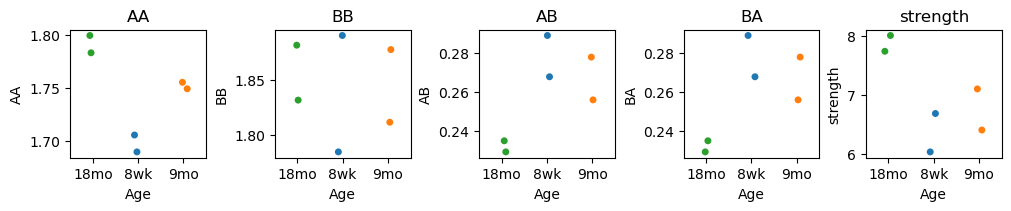

In [52]:
fig, axes = plt.subplots(figsize= (10,2), ncols = 5, sharex='all', constrained_layout = True)
for category, ax in zip(['AA', 'BB', 'AB','BA', 'strength'],axes.ravel()):
    sns.stripplot(data=stats, 
                  x="Age", y=category, 
                  hue="Age", legend=False,
                  hue_order = ['8wk','9mo','18mo'],
                  ax = ax)
    ax.set_title(f'{category}')
    